c:\Users\natra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


R² Score (Test Set): 0.999
RMSE (Test Set): 0.269
MAE (Test Set): 0.195
Predictions saved to 'nofinetuning.csv'


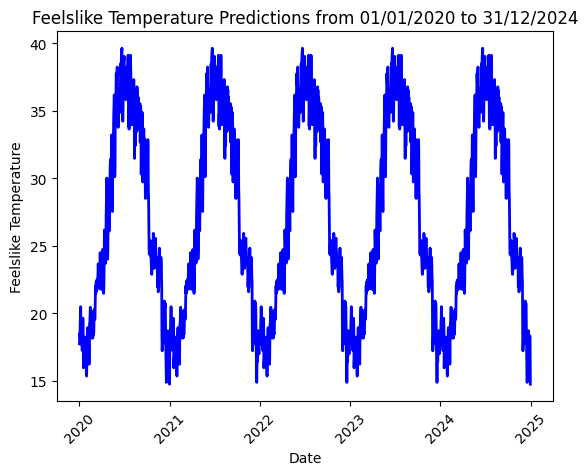

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load the dataset
file_path = '../../../dataset/data.csv'  # Adjust the path to your dataset
data = pd.read_csv(file_path)

# Prepare the data for Polynomial Regression
X = data[['temp', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'dew', 'sealevelpressure']]
y = data['feelslike']

# Include the 'datetime' in the dataset
data['datetime'] = pd.to_datetime(data['datetime'], format='%m/%d/%Y')
data['day_of_year'] = data['datetime'].dt.dayofyear

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Apply Polynomial Features (e.g., degree = 2 for quadratic terms)
degree = 2
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Step 2: Initialize and train the Linear Regression model on the polynomial features
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict on the test set
y_pred_test = model.predict(X_test_poly)

# Step 3: Calculate R², RMSE, and MAE for the test set
r2 = r2_score(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

# Display the performance metrics
print(f"R² Score (Test Set): {r2:.3f}")
print(f"RMSE (Test Set): {rmse:.3f}")
print(f"MAE (Test Set): {mae:.3f}")

# Step 4: Generate a date range from 21/08/2024 to 31/12/2024
future_dates = pd.date_range(start='2020-01-01', end='2024-12-31')
future_day_of_year = future_dates.dayofyear

# Step 5: Use historical averages for each day of the year to simulate future features
# Group the historical data by 'day_of_year' and calculate the average for each feature
historical_averages = data.groupby('day_of_year')[['temp','tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'humidity', 'dew', 'sealevelpressure']].mean()

# Create future features by using historical averages for the corresponding day of the year
future_features = pd.DataFrame({
    'temp': [historical_averages.loc[day, 'temp'] for day in future_day_of_year],
    'tempmax': [historical_averages.loc[day, 'tempmax'] for day in future_day_of_year],
    'tempmin': [historical_averages.loc[day, 'tempmin'] for day in future_day_of_year],
    'feelslikemax': [historical_averages.loc[day, 'feelslikemax'] for day in future_day_of_year],
    'feelslikemin': [historical_averages.loc[day, 'feelslikemin'] for day in future_day_of_year],
    'dew': [historical_averages.loc[day, 'dew'] for day in future_day_of_year],
    'sealevelpressure': [historical_averages.loc[day, 'sealevelpressure'] for day in future_day_of_year]
    
})

# Step 6: Apply polynomial transformation on the future features
future_features_poly = poly.transform(future_features)

# Step 7: Predict the feelslike temperature for the future date range
feelslike_predictions = model.predict(future_features_poly)

# Step 8: Create a DataFrame to store the predictions
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Feelslike': feelslike_predictions
})

# Step 9: Save the predicted values to a CSV file
future_predictions_df.to_csv('nofinetuning.csv', index=False)
print("Predictions saved to 'nofinetuning.csv'")

# Step 10: Plot the predicted feelslike temperatures
plt.plot(future_dates, feelslike_predictions, label='Predicted Feelslike', color='blue', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Feelslike Temperature')
plt.title('Feelslike Temperature Predictions from 01/01/2020 to 31/12/2024')
plt.xticks(rotation=45)
plt.show()
